In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import requests
from bs4 import BeautifulSoup

from sqlalchemy import create_engine

import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error

from xgboost import XGBRegressor, XGBClassifier


# Instructors Solution
### Reading the CSV, TSV, and JSON files
>1. data_0.tsv
<div>
<img src="media/data_0.png" width="500"/>
</div>

In [2]:
data_0 = pd.read_csv('data/data_0.tsv', sep = '\t', index_col = 0)
data_0.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season
0,1.618981e+09,6.4,90.0,0.0,7.4,1019.2,35.0,spring
1,1.664172e+09,11.9,NaN,NaN,NaN,NaN,NaN,autumn
2,1.666717e+09,14.2,84.0,0.0,11.1,1010.4,141.0,autumn
3,1.674011e+09,-2.9,96.0,0.0,11.1,994.5,256.0,winter
4,1.648228e+09,14.2,49.0,0.0,NaN,NaN,NaN,spring


>2. data_1.json
<div>
<img src="media/data_1.png" width="1000"/>
</div>

In [3]:
data_1 = pd.read_json('data/data_1.json', orient = 'table')
data_1.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season
0,2022-08-02 13:00:00,26.3,53.0,0.0,27.8,1014.4,243.0,summer
1,2023-04-30 10:00:00,14.8,59.0,0.0,13.0,1021.3,164.0,spring
2,2021-06-15 19:00:00,18.1,68.0,0.0,NaN,NaN,NaN,spring
3,2022-06-03 11:00:00,22.0,41.0,0.0,20.5,1017.0,80.0,spring
4,2022-11-03 04:00:00,11.6,90.0,4.2,14.8,1003.8,200.0,autumn


In [4]:
data_1['timestamp'] = data_1['timestamp'].apply(lambda x: datetime.timestamp(x))

>3. data_2.csv
<div>
<img src="media/data_2.png" width="500"/>
</div>

In [5]:
data_2 = pd.read_csv('data/data_2.csv', index_col = 0)
data_2.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season
0,1.624540e+09,19.6,58.0,0.0,13.0,1021.1,288.0,summer
1,1.651237e+09,10.9,57.0,0.0,NaN,NaN,NaN,spring
2,1.619507e+09,6.6,74.0,0.0,5.5,1012.3,112.0,spring
3,1.639584e+09,10.4,NaN,NaN,9.3,1031.5,238.0,autumn
4,1.622804e+09,15.9,80.0,1.0,NaN,NaN,NaN,spring


>3. data_3.csv
<div>
<img src="media/data_3.png" width="500"/>
</div>

The 'rhum' has a '%' that should not be there, and the 'season' data is not capitalized in the same way.

In [6]:
data_3 = pd.read_csv('data/data_3.csv', index_col = 0)
data_3['rhum'] = data_3['rhum'].apply(lambda x: float(x.replace('%','')))
data_3['season'] = data_3['season'].apply(lambda x: x.lower())
data_3.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season
0,1.684310e+09,12.9,73.0,0.0,9.3,1029.2,330.0,spring
1,1.633590e+09,13.6,94.0,0.0,9.3,1025.7,217.0,autumn
2,1.633694e+09,17.9,78.0,0.0,5.5,1029.8,168.0,autumn
3,1.655417e+09,17.4,66.0,0.0,9.3,1022.3,190.0,spring
4,1.639123e+09,4.2,86.0,0.0,29.6,995.8,308.0,autumn


In [7]:
df = pd.concat([data_0, data_1, data_2, data_3])
df.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season
0,1.618981e+09,6.4,90.0,0.0,7.4,1019.2,35.0,spring
1,1.664172e+09,11.9,NaN,NaN,NaN,NaN,NaN,autumn
2,1.666717e+09,14.2,84.0,0.0,11.1,1010.4,141.0,autumn
3,1.674011e+09,-2.9,96.0,0.0,11.1,994.5,256.0,winter
4,1.648228e+09,14.2,49.0,0.0,NaN,NaN,NaN,spring


### Website

Let's start by examining the page's html content

![Images Table](media/page1.png)

![Weather Coder Table](media/page2.png)

We can see that there are two tables. The second table is the one we want to scrape.

The table's content is split into "table header" (theader) and "table body" (tbody). The table header contains the column names and the table body contains the data.

This will be useful later.

#### Website's html content

Now, let's get the html content by sending a GET request to the url

In [8]:
# URL of the HTML file or the web page
url = 'https://s02-infrastructure.s3.eu-west-1.amazonaws.com/hackathon-02-batch7/index.html'

# Send a GET request to the URL and retrieve the HTML content
response = requests.get(url)
html_content = response.text

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

#### Table data

First, we want to find the table identified by the 'data-table' id

In [9]:
table = soup.find("table", id = 'data-table')

In [10]:
table

<table id="data-table">
<thead>
<tr>
<th>timestamp</th>
<th>weco</th>
</tr>
</thead>
<tbody>
<tr>
<td>1656896400</td>
<td>Fair</td>
</tr>
<tr>
<td>1685127600</td>
<td>Clear</td>
</tr>
<tr>
<td>1622311200</td>
<td>Fair</td>
</tr>
<tr>
<td>1666148400</td>
<td>Cloudy</td>
</tr>
<tr>
<td>1624255200</td>
<td>Light Rain</td>
</tr>
<tr>
<td>1688338800</td>
<td>Fair</td>
</tr>
<tr>
<td>1682701200</td>
<td>Cloudy</td>
</tr>
<tr>
<td>1645639200</td>
<td>Overcast</td>
</tr>
<tr>
<td>1670284800</td>
<td>Overcast</td>
</tr>
<tr>
<td>1689678000</td>
<td>Cloudy</td>
</tr>
<tr>
<td>1650340800</td>
<td>Cloudy</td>
</tr>
<tr>
<td>1634205600</td>
<td>Cloudy</td>
</tr>
<tr>
<td>1649520000</td>
<td>Fair</td>
</tr>
<tr>
<td>1666000800</td>
<td>Overcast</td>
</tr>
<tr>
<td>1660071600</td>
<td>Fair</td>
</tr>
<tr>
<td>1618333200</td>
<td>Fair</td>
</tr>
<tr>
<td>1691708400</td>
<td>Fair</td>
</tr>
<tr>
<td>1652803200</td>
<td>Fair</td>
</tr>
<tr>
<td>1628038800</td>
<td>Fair</td>
</tr>
<tr>
<td>1693792800</td

Now that we have the table, let's begin by saving the column names.

As we've seen before, the column names are in the table header (theader).

In [11]:
def get_table_columns(table_header):
    columns = []
    for header in table_header.find_all("th"):
        columns.append(header.text.strip("\n"))

    return columns

In [12]:
table_header = table.find("thead")

columns = get_table_columns(table_header)

In [13]:
columns

['timestamp', 'weco']

Next we can get the data, which is stored on the table rows (tr) inside the table body (tbody)

In [14]:
def get_table_data(table_body):
    table_rows = table_body.find_all('tr')
    
    table_data = []
    for row in table_rows:
        row_data = [cell.get_text(strip=True) for cell in row.select('td')]
        table_data.append(row_data)

    return table_data

In [15]:
table_body = table.find("tbody")
table_data = get_table_data(table_body)

In [16]:
table_data

[['1656896400', 'Fair'],
 ['1685127600', 'Clear'],
 ['1622311200', 'Fair'],
 ['1666148400', 'Cloudy'],
 ['1624255200', 'Light Rain'],
 ['1688338800', 'Fair'],
 ['1682701200', 'Cloudy'],
 ['1645639200', 'Overcast'],
 ['1670284800', 'Overcast'],
 ['1689678000', 'Cloudy'],
 ['1650340800', 'Cloudy'],
 ['1634205600', 'Cloudy'],
 ['1649520000', 'Fair'],
 ['1666000800', 'Overcast'],
 ['1660071600', 'Fair'],
 ['1618333200', 'Fair'],
 ['1691708400', 'Fair'],
 ['1652803200', 'Fair'],
 ['1628038800', 'Fair'],
 ['1693792800', 'Fair'],
 ['1620759600', 'Fair'],
 ['1657188000', 'Cloudy'],
 ['1635847200', 'Fair'],
 ['1694919600', 'Cloudy'],
 ['1690405200', 'Heavy Rain'],
 ['1653476400', 'Cloudy'],
 ['1694998800', 'Light Rain'],
 ['1673524800', 'Light Rain'],
 ['1653224400', 'Fair'],
 ['1678122000', 'Light Rain'],
 ['1675414800', 'Overcast'],
 ['1682967600', 'Fair'],
 ['1622869200', 'Cloudy'],
 ['1634328000', 'Cloudy'],
 ['1657807200', 'Fair'],
 ['1619874000', 'Fair'],
 ['1693440000', 'Cloudy'],
 ['165

#### Save data to dataframe

Lastly, we just need to create pandas dataframe with the retrieved information to save it as a csv file.

In [17]:
df_webscraping = pd.DataFrame(table_data, columns=columns)
df_webscraping.head()

,timestamp,weco
0,1656896400,Fair
1,1685127600,Clear
2,1622311200,Fair
3,1666148400,Cloudy
4,1624255200,Light Rain


In [18]:
df_webscraping.to_csv('data/web_scrapping.csv')

### API

In [19]:
base_url = 'https://hckt02-api.lisbondatascience.org/hckt_api_batch/'
all_data = []
i = 0

while True:
    url = f'{base_url}{i}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        
        if not data:  
            break
        
        all_data.extend(data)
        i += 1
    else:
        print(f'Failed to retrieve data for {i}: {response.status_code}')
        break
        
df_api = pd.DataFrame(all_data)
df_api


,timestamp,count
0,1656896400,0
1,1685127600,157
2,1622311200,0
3,1666148400,0
4,1624255200,1342
...,...,...
15679,1676451600,0
15680,1635807600,0
15681,1630807200,0
15682,1629262800,125


### Database

In [20]:
# Db settings - PostgreSQL
username = 'ldsa_student'
password = 'R4Fr4P3aAgMYBqqP'
host_name = 'batch4-s02-db-instance.ctq2kxc7kx1i.eu-west-1.rds.amazonaws.com'
port = 5432
db_name = 'hckt2_students'
schema = 'public'

conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)
conn_args = {'options': '-csearch_path={}'.format(schema)}

engine = create_engine(conn_str, connect_args=conn_args)

In [21]:
# Read each table from the database
df_wind = pd.read_sql_query('SELECT * FROM wind;', engine)
df_water = pd.read_sql_query('SELECT * FROM water;', engine)

In [22]:
# Merge the two tables
df_sql = pd.merge(df_wind, df_water, on='timestamp', how='outer')

df_sql

,timestamp,wspd_db,wdir_db,pres_db,rhum_db,prcp_db
0,1617339600,NaN,NaN,NaN,84.0,0.0
1,1617343200,NaN,NaN,NaN,81.0,0.0
2,1617390000,16.7,23.0,1031.2,NaN,NaN
3,1617426000,NaN,NaN,NaN,83.0,0.0
4,1617440400,22.2,28.0,1032.8,NaN,NaN
...,...,...,...,...,...,...
5626,1697968800,13.0,218.0,1005.8,NaN,NaN
5627,1697976000,13.0,214.0,1006.7,NaN,NaN
5628,1697990400,NaN,NaN,NaN,76.0,0.0
5629,1698001200,NaN,NaN,NaN,87.0,0.0


In [23]:
df_sql.to_csv('data/sql.csv')

## Merging the dataframes

There are two ways of replacing the missing values on the original dataset by **the values retieved from the database.**

#### Option 1:

Using fillna()

In [24]:
# Join the two dataframes
merged_df = pd.merge(df, df_sql, on='timestamp', how='inner', suffixes=('', '_db'))

merged_df

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season,wspd_db,wdir_db,pres_db,rhum_db,prcp_db
0,1.664172e+09,11.9,NaN,NaN,NaN,NaN,NaN,autumn,18.5,264.0,1001.0,86.0,0.3
1,1.648228e+09,14.2,49.0,0.0,NaN,NaN,NaN,spring,13.0,80.0,1031.1,NaN,NaN
2,1.639386e+09,9.9,NaN,NaN,NaN,NaN,NaN,autumn,14.8,200.0,1023.3,93.0,0.0
3,1.663182e+09,15.6,NaN,NaN,11.1,1008.3,335.0,summer,NaN,NaN,NaN,77.0,0.0
4,1.678147e+09,4.3,NaN,NaN,13.0,1001.2,250.0,winter,NaN,NaN,NaN,92.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5360,1.643310e+09,5.9,NaN,NaN,11.1,1031.2,296.0,winter,NaN,NaN,NaN,86.0,0.0
5361,1.654304e+09,13.0,NaN,NaN,20.5,1020.0,50.0,spring,NaN,NaN,NaN,77.0,2.5
5362,1.619237e+09,4.4,NaN,NaN,NaN,NaN,NaN,spring,9.3,72.0,1027.9,89.0,0.0
5363,1.657094e+09,17.4,69.0,0.0,NaN,NaN,NaN,summer,13.0,295.0,1027.5,NaN,NaN


In [25]:
# Define the columns to fill
columns_to_fill = ['wspd', 'pres', 'wdir', 'rhum', 'prcp']

# Fill the columns with the values from the sql tables
for col in columns_to_fill:
    merged_df[col] = merged_df[col].fillna(merged_df[f'{col}_db'])

# Drop columns that are not needed
merged_df = merged_df.drop(columns=['wspd_db', 'wdir_db', 'pres_db', 'rhum_db', 'prcp_db'])

#### Option 2:

Using combine_first()

In [26]:
# #Set timestamp as index
# df = df.set_index('timestamp')
# df_sql = df_sql.set_index('timestamp')

# #Fill missing values of df with values from df_sql
# df['wspd'] = df['wspd'].combine_first(df_sql['wspd_db'])
# df['wdir'] = df['wdir'].combine_first(df_sql['wdir_db'])
# df['pres'] = df['pres'].combine_first(df_sql['pres_db'])
# df['rhum'] = df['rhum'].combine_first(df_sql['rhum_db'])
# df['prcp'] = df['prcp'].combine_first(df_sql['prcp_db'])

The *data from the webscraping* is just one column. As such, after setting the index to 'timestamp', it can just be added to the merged_df.

In [27]:
merged_df['timestamp'] = merged_df['timestamp'].apply(lambda x: str(int(x)))
merged_df = merged_df.merge(df_webscraping, on='timestamp', how='inner')
merged_df.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season,weco
0,1664172000,11.9,86.0,0.3,18.5,1001.0,264.0,autumn,Light Rain
1,1648227600,14.2,49.0,0.0,13.0,1031.1,80.0,spring,Fair
2,1639386000,9.9,93.0,0.0,14.8,1023.3,200.0,autumn,Overcast
3,1663182000,15.6,77.0,0.0,11.1,1008.3,335.0,summer,Fair
4,1678147200,4.3,92.0,0.0,13.0,1001.2,250.0,winter,Light Rain


Same reasoning for the **data retrieved from the API**.

In [28]:
df_api['timestamp'] = df_api['timestamp'].apply(lambda x: str(int(x)))
merged_df = merged_df.merge(df_api, on='timestamp', how='inner')
merged_df['timestamp'] = pd.to_numeric(merged_df['timestamp'])
merged_df.head()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,season,weco,count
0,1664172000,11.9,86.0,0.3,18.5,1001.0,264.0,autumn,Light Rain,769
1,1648227600,14.2,49.0,0.0,13.0,1031.1,80.0,spring,Fair,576
2,1639386000,9.9,93.0,0.0,14.8,1023.3,200.0,autumn,Overcast,986
3,1663182000,15.6,77.0,0.0,11.1,1008.3,335.0,summer,Fair,30
4,1678147200,4.3,92.0,0.0,13.0,1001.2,250.0,winter,Light Rain,0


We have the full dataset ready for EDA and modelling!

# EDA

In [29]:
merged_df.dtypes

timestamp      int64
temp         float64
rhum         float64
prcp         float64
wspd         float64
pres         float64
wdir         float64
season        object
weco          object
count          int64
dtype: object

In [30]:
merged_df.isnull().sum()

timestamp     0
temp          0
rhum         55
prcp         55
wspd         61
pres         61
wdir         61
season        0
weco          0
count         0
dtype: int64

In [31]:
merged_df.dropna(inplace = True)

In [32]:
merged_df.duplicated().sum()

0

In [33]:
merged_df.describe()

,timestamp,temp,rhum,prcp,wspd,pres,wdir,count
count,5.249000e+03,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000
mean,1.657943e+09,11.600781,79.684702,0.071004,14.070280,1016.129625,194.378167,871.208802
std,2.331341e+07,6.094926,14.897357,0.313288,6.513638,10.403927,95.060117,4511.274467
min,1.617343e+09,-4.000000,20.000000,0.000000,1.800000,976.300000,1.000000,0.000000
25%,1.637640e+09,7.300000,71.000000,0.000000,9.300000,1009.800000,122.000000,0.000000
50%,1.658491e+09,11.700000,84.000000,0.000000,13.000000,1016.800000,216.000000,0.000000
75%,1.678108e+09,15.800000,91.000000,0.000000,18.500000,1023.500000,260.000000,87.000000
max,1.698005e+09,34.800000,100.000000,5.400000,61.100000,1046.500000,360.000000,95848.000000


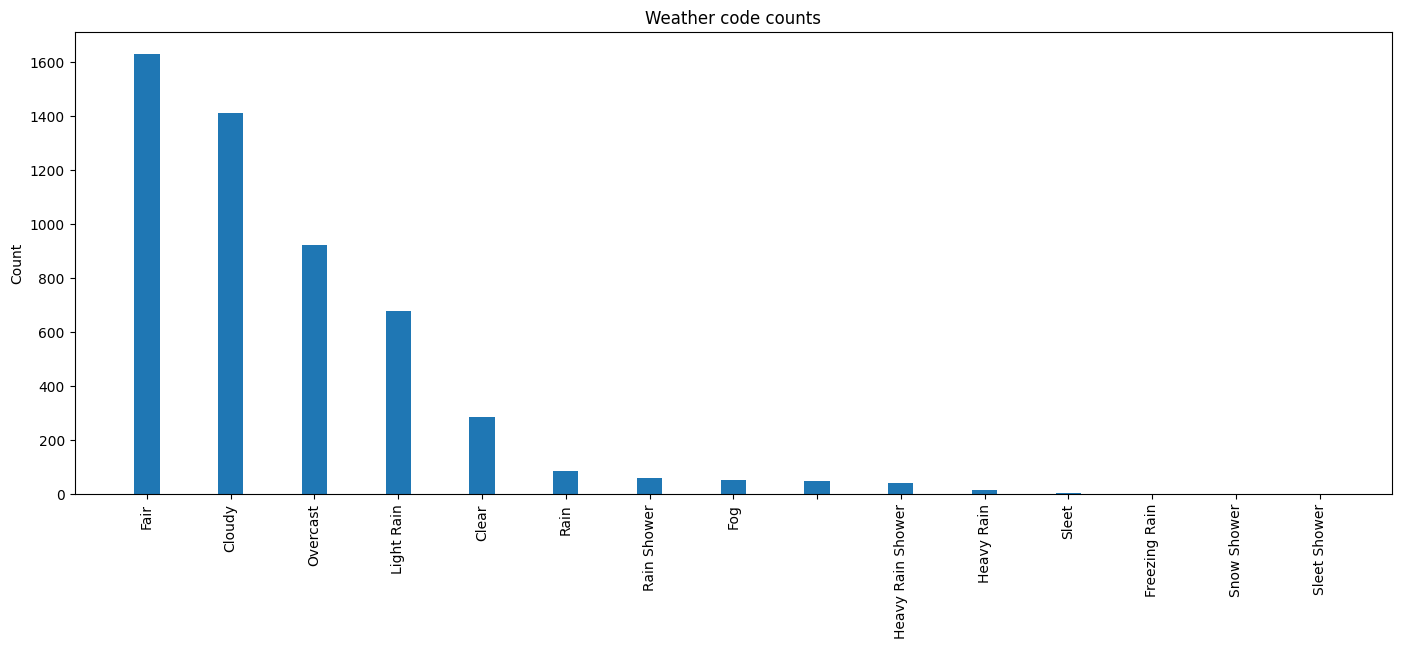

In [34]:
categories = merged_df['weco'].value_counts().index
counts = merged_df['weco'].value_counts().values
plt.figure(figsize=(17,6))
plt.title('Weather code counts')
plt.ylabel('Count')
plt.bar(categories, counts, width=0.3)
plt.xticks(rotation='vertical')
plt.show()

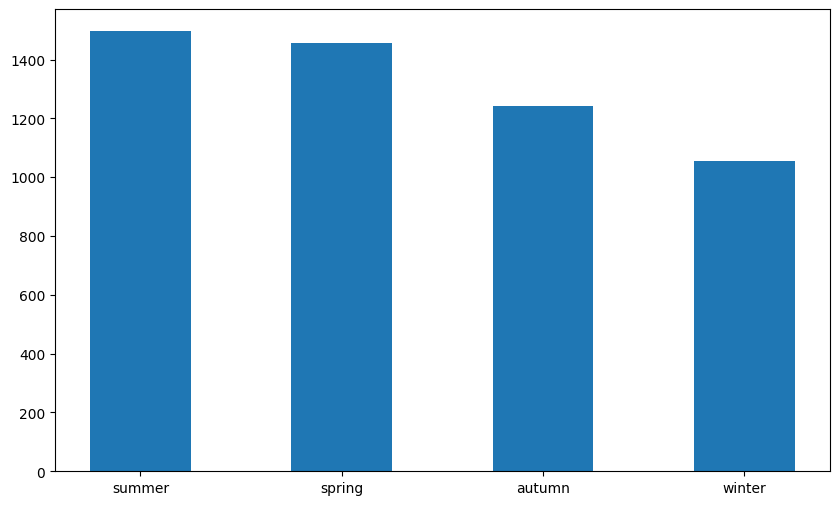

In [35]:
categories = merged_df['season'].value_counts().index
counts = merged_df['season'].value_counts().values
plt.figure(figsize=(10,6))
plt.bar(categories, counts, width=0.5)
plt.show()

In [36]:
df_date = merged_df['timestamp'].apply(lambda x: datetime.fromtimestamp(float(x)))

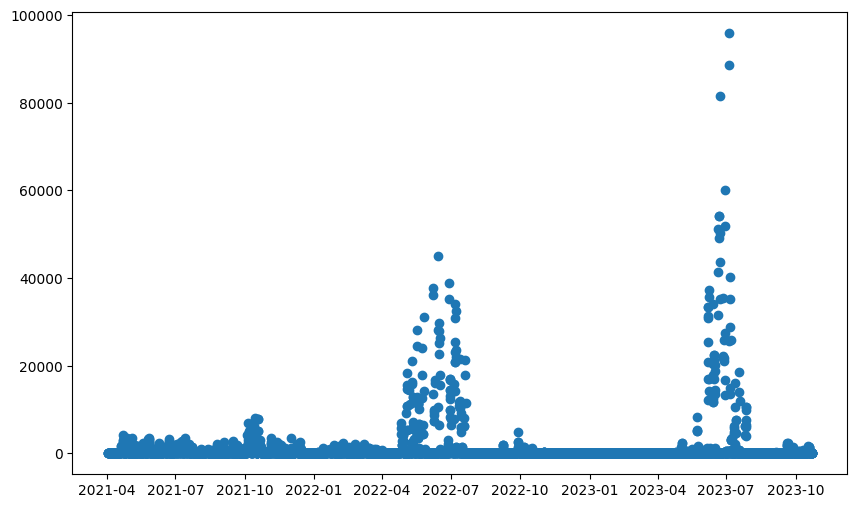

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(x = df_date, y = merged_df['count'])
plt.show()

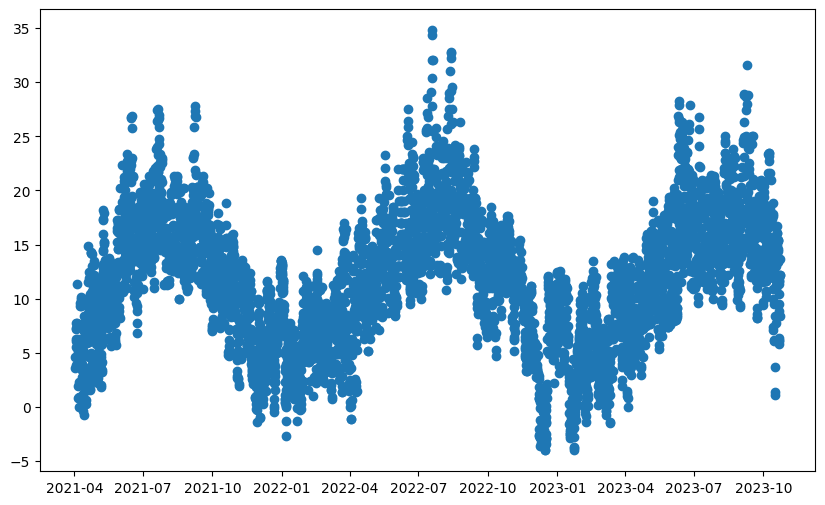

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(x = df_date, y = merged_df['temp'])
plt.show()

### Numerical Feature Correlation

In [39]:
corr_mat = df.select_dtypes(exclude = 'object').corr(method = 'pearson')
 
lower_triangle_mask = np.triu(np.ones(corr_mat.shape)).astype(bool)
corr_mat_lower = corr_mat.mask(lower_triangle_mask)

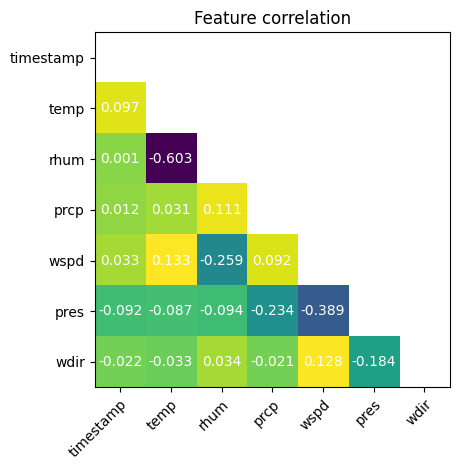

In [70]:
fig, ax = plt.subplots()
im = ax.imshow(corr_mat_lower)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(corr_mat_lower.columns)), labels=corr_mat_lower.columns)
ax.set_yticks(np.arange(len(corr_mat_lower.columns)), labels=corr_mat_lower.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(corr_mat_lower.columns)):
    for j in range(len(corr_mat_lower.columns)):
        text = ax.text(j, i, round(corr_mat_lower.iloc[i, j], 3),
                       ha="center", va="center", color="w")

ax.set_title("Feature correlation")
fig.tight_layout()
plt.show()

# Modelling

In [40]:
features = ['temp', 'rhum', 'wspd', 'wdir', 'weco', 'prcp', 'pres',
       'season','timestamp']
target = 'count'

df_train, df_val = train_test_split(merged_df, test_size = 0.2, random_state = 42)

X = merged_df[features]
y = merged_df[target]
X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]
y_val =  df_val[target]

In [41]:
X_train

,temp,rhum,wspd,wdir,weco,prcp,pres,season,timestamp
378,5.3,100.0,9.3,358.0,Overcast,0.0,1019.6,autumn,1669708800
4904,15.0,88.0,20.4,206.0,Overcast,0.0,1013.0,autumn,1664928000
3585,15.7,88.0,18.5,217.0,Fair,0.0,1015.1,autumn,1696975200
2619,19.0,52.0,24.1,220.0,,0.0,1017.0,spring,1654790400
1597,16.1,55.0,9.3,328.0,Cloudy,0.0,1028.2,spring,1684324800
...,...,...,...,...,...,...,...,...,...
3208,8.1,84.0,7.4,269.0,Cloudy,0.0,1025.9,autumn,1637168400
3888,12.9,97.0,11.1,339.0,Light Rain,0.3,1011.7,autumn,1697083200
5307,21.2,62.0,22.2,351.0,Cloudy,0.0,1021.8,summer,1626346800
5342,1.1,97.0,16.7,78.0,Light Rain,0.5,991.1,winter,1678287600


In [42]:
def create_time_features(X):
    df = X.copy()
    # Convert the 'timestamp' column to datetime
    df['timestamp'] = df['timestamp'].apply(datetime.fromtimestamp)
    
    # Extract time features
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour'] = df['timestamp'].dt.hour
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df = df.drop(columns=['timestamp'])
    
    return df

In [43]:
X_train = create_time_features(X_train)

In [44]:
X_train

,temp,rhum,wspd,wdir,weco,prcp,pres,season,year,month,day,day_of_week,hour,is_weekend
378,5.3,100.0,9.3,358.0,Overcast,0.0,1019.6,autumn,2022,11,29,1,8,0
4904,15.0,88.0,20.4,206.0,Overcast,0.0,1013.0,autumn,2022,10,5,2,1,0
3585,15.7,88.0,18.5,217.0,Fair,0.0,1015.1,autumn,2023,10,10,1,23,0
2619,19.0,52.0,24.1,220.0,,0.0,1017.0,spring,2022,6,9,3,17,0
1597,16.1,55.0,9.3,328.0,Cloudy,0.0,1028.2,spring,2023,5,17,2,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,8.1,84.0,7.4,269.0,Cloudy,0.0,1025.9,autumn,2021,11,17,2,17,0
3888,12.9,97.0,11.1,339.0,Light Rain,0.3,1011.7,autumn,2023,10,12,3,5,0
5307,21.2,62.0,22.2,351.0,Cloudy,0.0,1021.8,summer,2021,7,15,3,12,0
5342,1.1,97.0,16.7,78.0,Light Rain,0.5,991.1,winter,2023,3,8,2,15,0


In [45]:
ohe = ce.OneHotEncoder(use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)

In [46]:
X_train_ohe

,temp,rhum,wspd,wdir,weco_Overcast,weco_Fair,weco_,weco_Cloudy,weco_Light Rain,weco_Clear,...,season_autumn,season_spring,season_winter,season_summer,year,month,day,day_of_week,hour,is_weekend
378,5.3,100.0,9.3,358.0,1,0,0,0,0,0,...,1,0,0,0,2022,11,29,1,8,0
4904,15.0,88.0,20.4,206.0,1,0,0,0,0,0,...,1,0,0,0,2022,10,5,2,1,0
3585,15.7,88.0,18.5,217.0,0,1,0,0,0,0,...,1,0,0,0,2023,10,10,1,23,0
2619,19.0,52.0,24.1,220.0,0,0,1,0,0,0,...,0,1,0,0,2022,6,9,3,17,0
1597,16.1,55.0,9.3,328.0,0,0,0,1,0,0,...,0,1,0,0,2023,5,17,2,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,8.1,84.0,7.4,269.0,0,0,0,1,0,0,...,1,0,0,0,2021,11,17,2,17,0
3888,12.9,97.0,11.1,339.0,0,0,0,0,1,0,...,1,0,0,0,2023,10,12,3,5,0
5307,21.2,62.0,22.2,351.0,0,0,0,1,0,0,...,0,0,0,1,2021,7,15,3,12,0
5342,1.1,97.0,16.7,78.0,0,0,0,0,1,0,...,0,0,1,0,2023,3,8,2,15,0


In [47]:
pipeline = Pipeline([
    ('fillna', SimpleImputer(strategy='median')),  # Then, impute missing values
    ('scaler', RobustScaler(with_centering=False))  # Finally, scale the features
])

X_train_prep = pipeline.fit_transform(X_train_ohe)

X_train_prep_df = pd.DataFrame(X_train_prep, columns=X_train_ohe.columns, index = X_train_ohe.index)

# Now X_train_prep_df is a DataFrame with the correct column names

# Parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    # Add more parameters here
}

# Cross-validator for time series
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search on hyper parameters
random_search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror'), param_distributions=param_grid, n_iter=100, scoring='r2',
    cv=tscv, verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train_prep_df, y_train)

# Best model
best_model = random_search.best_estimator_

# You can now use `best_model` for predictions and further analysis

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [49]:
X_val_ohe = ohe.transform(create_time_features(X_val))
X_val_prep = pipeline.transform(X_val_ohe)
X_val_prep_df = pd.DataFrame(X_val_prep, columns=X_val_ohe.columns, index = X_val_ohe.index)
display(X_val_prep_df)
mean_squared_error(y_pred = best_model.predict(X_val_prep_df), y_true = y_val)

,temp,rhum,wspd,wdir,weco_Overcast,weco_Fair,weco_,weco_Cloudy,weco_Light Rain,weco_Clear,...,season_autumn,season_spring,season_winter,season_summer,year,month,day,day_of_week,hour,is_weekend
1440,0.694118,3.95,3.423913,1.792857,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1011.5,0.2,0.866667,1.00,0.500000,0.0
2816,1.494118,3.70,1.608696,1.528571,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1010.5,1.0,1.066667,1.50,0.916667,1.0
3763,1.752941,4.25,1.608696,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1010.5,1.2,1.266667,1.25,1.583333,1.0
2628,0.741176,4.55,1.010870,1.092857,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1011.0,0.2,0.666667,0.00,1.416667,0.0
3018,1.682353,2.95,2.217391,0.271429,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1011.5,1.2,0.133333,1.00,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,-0.164706,4.60,1.010870,1.285714,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1011.0,2.4,1.133333,1.25,0.750000,1.0
3211,1.235294,4.15,1.815217,1.764286,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1011.0,2.4,1.333333,0.25,0.916667,0.0
859,1.905882,4.55,2.217391,1.285714,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1010.5,1.8,1.800000,0.00,0.500000,0.0
3250,1.564706,2.70,1.413043,1.042857,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1011.0,0.6,1.400000,0.00,1.083333,0.0


5142087.365307713

In [51]:
r2_score(y_pred = best_model.predict(X_val_prep_df), y_true = y_val)

0.6876252537563181

In [55]:
output = pd.concat([pd.Series(best_model.predict(X_val_prep_df),index=X_val.index,name="prediction"), y_val],axis=1)

In [57]:
def non_neg_funct(x):
    if x > 0:
        return x
    else:
        return 0
        
output["prediction"] = output["prediction"].apply(non_neg_funct)
output["diff"] = np.abs(output["prediction"]-output["count"])


In [58]:
output

,prediction,count,diff
1440,45.976536,0,45.976536
2816,294.887939,11,283.887939
3763,154.443512,210,55.556488
2628,248.396027,105,143.396027
3018,0.000000,58,58.000000
...,...,...,...
376,129.651810,0,129.651810
3211,269.051147,0,269.051147
859,185.724731,328,142.275269
3250,399.024963,310,89.024963


In [59]:
output.sort_values("diff", ascending = False)

,prediction,count,diff
4541,8322.650391,30773,22450.349609
3045,3043.653809,24059,21015.346191
438,17745.333984,37694,19948.666016
4526,4631.085449,22641,18009.914551
2990,15580.408203,32571,16990.591797
...,...,...,...
4406,0.000000,0,0.000000
443,0.000000,0,0.000000
3634,0.000000,0,0.000000
4391,0.000000,0,0.000000


# Part II: mixing models

## Data Viz

<Axes: >

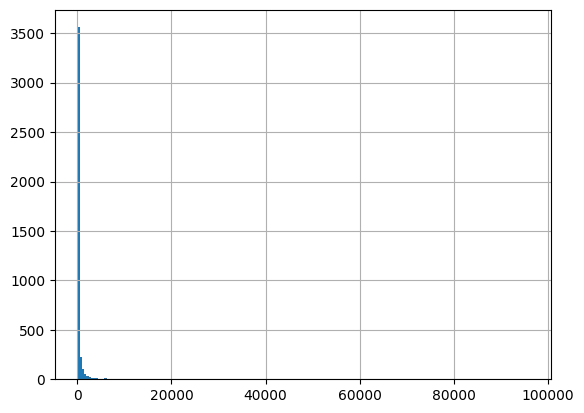

In [60]:
y_train.hist(bins=200)

In [65]:
y_train_binary = (y_train > 0).astype(int)
y_train_binary

378     0
4904    0
3585    0
2619    1
1597    1
       ..
3208    1
3888    0
5307    1
5342    0
860     0
Name: count, Length: 4199, dtype: int64

## Classifier

In [62]:
# Parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [5, 50, 100, 200, 500],
    'min_child_weight': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    # Add more parameters here
}


# Randomized search on hyper parameters
random_search = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='auc'), param_distributions=param_grid, n_iter=100, scoring='roc_auc',
    cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
random_search.fit(X_train_prep_df, y_train_binary)

# Best model
best_model = random_search.best_estimator_

# You can now use `best_model` for predictions and further analysis


Fitting 5 folds for each of 100 candidates, totalling 500 fits


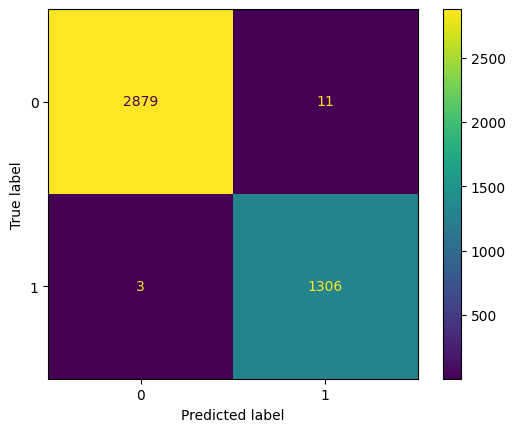

In [63]:
conf_mat = confusion_matrix(y_pred = best_model.predict(X_train_prep_df), y_true = y_train_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [64]:
pd.concat([X_train_prep_df, 
           pd.Series(best_model.predict(X_train_prep_df), index = X_train_prep_df.index, name = "prediction"),
          pd.Series(y_train, index = y_train.index, name = "value")], axis=1)

,temp,rhum,wspd,wdir,weco_Overcast,weco_Fair,weco_,weco_Cloudy,weco_Light Rain,weco_Clear,...,season_winter,season_summer,year,month,day,day_of_week,hour,is_weekend,prediction,value
378,0.623529,5.00,1.010870,2.557143,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1011.0,2.2,1.933333,0.25,0.666667,0.0,0,0
4904,1.764706,4.40,2.217391,1.471429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1011.0,2.0,0.333333,0.50,0.083333,0.0,0,0
3585,1.847059,4.40,2.010870,1.550000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1011.5,2.0,0.666667,0.25,1.916667,0.0,0,0
2619,2.235294,2.60,2.619565,1.571429,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1011.0,1.2,0.600000,0.75,1.416667,0.0,1,15950
1597,1.894118,2.75,1.010870,2.342857,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1011.5,1.0,1.133333,0.50,1.083333,0.0,1,342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,0.952941,4.20,0.804348,1.921429,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1010.5,2.2,1.133333,0.50,1.416667,0.0,1,1808
3888,1.517647,4.85,1.206522,2.421429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1011.5,2.0,0.800000,0.75,0.416667,0.0,0,0
5307,2.494118,3.10,2.413043,2.507143,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1010.5,1.4,1.000000,0.75,1.000000,0.0,1,990
5342,0.129412,4.85,1.815217,0.557143,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1011.5,0.6,0.533333,0.50,1.250000,0.0,0,0


In [66]:
regression_dataset = pd.concat([
    X_train_prep_df, 
    pd.Series(best_model.predict(X_train_prep_df), index = X_train_prep_df.index, name = "prediction"),
    pd.Series(y_train, index = y_train.index, name = "value")
    ], 
axis=1)

regression_dataset = regression_dataset[regression_dataset.prediction == 1].drop(columns = ["prediction"])

In [67]:
regression_dataset

,temp,rhum,wspd,wdir,weco_Overcast,weco_Fair,weco_,weco_Cloudy,weco_Light Rain,weco_Clear,...,season_spring,season_winter,season_summer,year,month,day,day_of_week,hour,is_weekend,value
2619,2.235294,2.60,2.619565,1.571429,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1011.0,1.2,0.600000,0.75,1.416667,0.0,15950
1597,1.894118,2.75,1.010870,2.342857,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1011.5,1.0,1.133333,0.50,1.083333,0.0,342
2875,1.000000,3.30,1.413043,0.864286,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1011.5,0.8,1.733333,0.50,1.583333,0.0,175
3691,1.247059,4.40,1.608696,1.435714,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1010.5,1.0,0.666667,0.00,0.500000,0.0,316
3871,1.847059,3.75,2.217391,1.800000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1010.5,2.0,0.066667,1.00,1.000000,0.0,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3560,1.529412,4.65,1.010870,1.828571,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1010.5,2.2,0.666667,0.50,1.083333,0.0,481
4542,2.082353,3.65,2.010870,1.514286,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1010.5,1.4,0.466667,0.50,1.500000,0.0,2272
466,1.729412,4.45,1.010870,1.207143,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1011.5,1.4,0.933333,1.00,0.500000,0.0,174
3208,0.952941,4.20,0.804348,1.921429,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1010.5,2.2,1.133333,0.50,1.416667,0.0,1808


In [151]:
X_reg = regression_dataset.drop(columns = ["value"])
y_reg = regression_dataset["value"]

param_grid = {
    'max_depth': [50, 100, 200, 500],
    'min_child_weight': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    # Add more parameters here
}


# Randomized search on hyper parameters
regressor_random_search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror'), param_distributions=param_grid, n_iter=100, scoring='neg_mean_absolute_error',
    cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Fit the model
regressor_random_search.fit(X_reg, y_reg)

# Best model
regressor_best_model = regressor_random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [152]:
mean_squared_error(y_pred = regressor_best_model.predict(X_reg), y_true = y_reg)

3.8023639170381793

In [153]:
r2_score(y_pred = regressor_best_model.predict(X_reg), y_true = y_reg)

0.9999999391132147

In [154]:
output = pd.concat([pd.Series(regressor_best_model.predict(X_reg),index=X_reg.index,name="prediction"), y_reg],axis=1)

In [155]:
def non_neg_funct(x):
    if x > 0:
        return x
    else:
        return 0
        
output["prediction"] = output["prediction"].apply(non_neg_funct)
output["diff"] = np.abs(output["prediction"]-output["value"])


In [156]:
output

,prediction,value,diff
2619,15949.994141,15950,0.005859
1597,342.001282,342,0.001282
2875,177.556976,175,2.556976
3691,315.890228,316,0.109772
3871,229.006393,229,0.006393
...,...,...,...
3560,480.987823,481,0.012177
4542,2272.074951,2272,0.074951
466,173.784988,174,0.215012
3208,1807.899414,1808,0.100586


In [157]:
output.sort_values("diff", ascending = False)

,prediction,value,diff
3398,95803.671875,95848,44.328125
4777,25557.873047,25530,27.873047
523,81453.976562,81481,27.023438
3611,88663.867188,88682,18.132812
2862,45104.535156,45118,13.464844
...,...,...,...
4869,422.999939,423,0.000061
1514,63.999950,64,0.000050
3279,194.000046,194,0.000046
528,0.000000,0,0.000000


In [158]:
basexgbreg = XGBRegressor(objective='reg:squarederror')

basexgbreg.fit(X_reg, y_reg)
mean_squared_error(basexgbreg.predict(X_reg), y_reg)

46983.643212631425

In [159]:
r2_score(basexgbreg.predict(X_reg), y_reg)

0.9992371926228867

In [160]:
output_basexgb = pd.concat([pd.Series(basexgbreg.predict(X_reg),index=X_reg.index,name="prediction"), y_reg],axis=1)
output_basexgb["prediction"] = output_basexgb["prediction"].apply(non_neg_funct)
output_basexgb["diff"] = np.abs(output_basexgb["prediction"]-output_basexgb["value"])
output_basexgb.sort_values("diff", ascending = False)

,prediction,value,diff
2980,6196.159668,7952,1755.840332
3759,34049.960938,35246,1196.039062
2679,14440.627930,13302,1138.627930
2520,9723.950195,10782,1058.049805
1848,34081.550781,35098,1016.449219
...,...,...,...
3092,2036.066284,2036,0.066284
3903,2309.038818,2309,0.038818
2595,0.000000,0,0.000000
2742,0.000000,0,0.000000


In [161]:
r2_score(y_pred = pd.Series(basexgbreg.predict(X_reg), name = "prediction", index = X_reg.index).apply(non_neg_funct), y_true = y_reg)

0.9992798675874531

In [162]:
dataset = pd.concat([
    X_train_prep_df, 
    pd.Series(best_model.predict(X_train_prep_df), index = X_train_prep_df.index, name = "prediction"),
    pd.Series(y_train, index = y_train.index, name = "value")
    ], 
axis=1)

dataset_0 = dataset[dataset.prediction == 0]

prediction_series = pd.concat([pd.Series(basexgbreg.predict(X_reg), name = "prediction", index = X_reg.index).apply(non_neg_funct), 
                               dataset_0.prediction])
true_series = dataset.value

In [163]:
final_series = pd.concat([prediction_series, true_series], axis=1)

In [164]:
final_series["diff"] = np.abs(final_series["prediction"]-final_series["value"]) 

In [165]:
final_series.sort_values("diff")

,prediction,value,diff
4846,0.000000,0,0.000000
3295,0.000000,0,0.000000
1286,0.000000,0,0.000000
349,0.000000,0,0.000000
2225,0.000000,0,0.000000
...,...,...,...
1848,34081.550781,35098,1016.449219
2520,9723.950195,10782,1058.049805
2679,14440.627930,13302,1138.627930
3759,34049.960938,35246,1196.039062


In [166]:
final_series["diff"].mean()

42.73908439919505

# Final Result

In [183]:
def preprocess_dataset(df: pd.DataFrame)-> pd.DataFrame:
    X = df.copy()
    X_time_feat = create_time_features(X)
    X_ohe = ohe.transform(X_time_feat)[X_train_ohe.columns.tolist()]
    X_prep = pipeline.transform(X_ohe)
    X_prep_df = pd.DataFrame(X_prep, columns=X_ohe.columns, index = X_ohe.index)
    return X_prep_df


In [170]:
def get_predictions(X: pd.DataFrame)->pd.Series:
    dataset = pd.concat([
        X, 
        pd.Series(best_model.predict(X), index = X.index, name = "prediction")
    ], 
    axis=1)
    
    regression_dataset = dataset[dataset.prediction == 1].drop(columns = ["prediction"])

    output = pd.Series(regressor_best_model.predict(regression_dataset),index=regression_dataset.index,name="prediction")
    output = output.apply(non_neg_funct)
    
    dataset_0 = dataset[dataset.prediction == 0]

    prediction_series = pd.concat([output, 
                                   dataset_0.prediction])
        
    base_prediction_series = pd.concat([pd.Series(basexgbreg.predict(regression_dataset), name = "prediction", index = regression_dataset.index).apply(non_neg_funct), 
                                       dataset_0.prediction])
    
    return prediction_series, base_prediction_series

        

In [181]:
test_df = pd.read_csv("data/test_data.csv", index_col = 0)
y_true = pd.read_csv("data/test_count.csv")

predict_series, base_predict_series = get_predictions(X_test)

predict_df = pd.concat([test_df["timestamp"], predict_series],axis=1)
base_predict_df = pd.concat([test_df["timestamp"], base_predict_series],axis=1)

predict_df.set_index("timestamp",inplace = True)
base_predict_df.set_index("timestamp",inplace = True)
y_true.set_index("timestamp",inplace = True)

mean_absolute_error(y_true=y_true,y_pred=predict_df)

542.3551340545085



My solution is better than your solution...



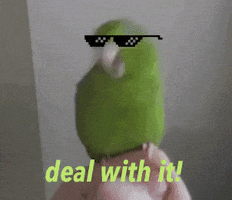

In [182]:
from IPython.display import Image
print("\n\nMy solution is better than your solution...\n")
Image(filename="data/200.gif", width=500, height=500)